# Подключение библиотек

In [ ]:
import os
import zipfile
import urllib.request
import glob

import albumentations as A
import cv2
import numpy as np
from matplotlib import pyplot as plt
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

Скачивание библиотеки для обучения ИНС и её подключение

In [ ]:
!git clone https://github.com/vitamin1312/BlissLearn.git

Cloning into 'BlissLearn'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 63 (delta 14), reused 58 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (63/63), 19.52 KiB | 9.76 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [ ]:
from BlissLearn.Core.BlissLearner import BlissLearner
from BlissLearn.Core.BlissCallbacks.Callbacks.CustomBlissCallbacks import CommonMetricsCallback, PrintCriteriaCallback

# Гиперпараметры обучения

In [ ]:
TARGET_SIZE = 256
BATCH_SIZE = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Скачивание набора данных

In [ ]:
# Скачивание архива
url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
filename = 'cats_and_dogs_filtered.zip'
urllib.request.urlretrieve(url, filename)

# Распаковка архив
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall()

# Настройка считывания и аугментации данных

In [ ]:
# https://albumentations.ai/docs/3-basic-usage/choosing-augmentations/


# Define a potentially very heavy augmentation pipeline
heavy_train_pipeline = A.Compose(
    [
        # 1. Initial Resizing/Cropping (Choose one strategy)
        # Option A: ImageNet style
        A.SmallestMaxSize(max_size=TARGET_SIZE, p=1.0),
        A.RandomCrop(height=TARGET_SIZE, width=TARGET_SIZE, p=1.0),

        # 2. Basic Geometric
        A.HorizontalFlip(p=0.5),

        # 3. Affine and Perspective
        A.OneOf([
            A.Affine(
                scale=(0.8, 1.2),      # Zoom
                rotate=(-15, 15),      # Rotate
                translate_percent=(-0.1, 0.1), # Translate
                shear=(-10, 10),          # Shear
                p=0.8 # Probability within OneOf
            ),
            A.Perspective(scale=(0.05, 0.1), p=0.8) # Probability within OneOf
        ], p=0.7), # Probability of applying Affine OR Perspective

        # 4. Dropout / Occlusion
        A.OneOf([
            A.CoarseDropout(num_holes_range=(1, 8), hole_height_range=(0.1, 0.25),
                        hole_width_range=(0.1, 0.25), fill_value=0, p=1.0),
            A.GridDropout(p=0.5),
        ], p=0.5), # Probability of applying one dropout type

        # 5. Color Space / Type Reduction
        A.OneOf([
            A.ToGray(p=0.3),
            A.ChannelDropout(channel_drop_range=(1, 1), fill_value=0, p=0.3),
        ], p=0.2), # Low probability for significant color changes

        # 6. Color Augmentations (Brightness, Contrast, Saturation, Hue)
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.8),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.8),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.8),
            A.RandomGamma(gamma_limit=(80, 120), p=0.8),
        ], p=0.7), # Apply one type of color jittering

        # 7. Blur
        A.OneOf([
            A.GaussianBlur(blur_limit=(3, 7), p=0.5),
            A.MedianBlur(blur_limit=5, p=0.5),
            A.MotionBlur(blur_limit=(3, 7), p=0.5),
        ], p=0.3), # Apply one type of blur

        # 8. Noise
        A.OneOf([
            A.GaussNoise(std_limit=(0.1, 0.2), p=0.5),
            A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=0.5),
            A.MultiplicativeNoise(multiplier=(0.9, 1.1), per_channel=True, p=0.5),
            A.SaltAndPepper(p=0.5)
        ], p=0.3), # Apply one type of noise

        # 9. Distortion (Use if relevant to domain)
        # A.OneOf([
        #     A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
        #     A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        #     A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=0.5),
        #     A.ThinPlateSpline(p=0.5)
        # ], p=0.3),

        # 10. Compression / Downscaling Artifacts
        A.OneOf([
            A.ImageCompression(quality_range=(20, 80), p=0.5),
            A.Downscale(scale_range=(0.25, 0.5), p=0.5),
        ], p=0.2),
    ],
)


valid_pipeline = A.Compose(
    [
        # 1. Initial Resizing/Cropping (Choose one strategy)
        # Option A: ImageNet style
        A.SmallestMaxSize(max_size=TARGET_SIZE, p=1.0),
        A.RandomCrop(height=TARGET_SIZE, width=TARGET_SIZE, p=1.0),

        # 2. Basic Geometric
        A.HorizontalFlip(p=0.5),

        # 3. Affine and Perspective
        A.OneOf([
            A.Affine(
                scale=(0.8, 1.2),      # Zoom
                rotate=(-15, 15),      # Rotate
                translate_percent=(-0.1, 0.1), # Translate
                shear=(-10, 10),          # Shear
                p=0.8 # Probability within OneOf
            ),
            A.Perspective(scale=(0.05, 0.1), p=0.8) # Probability within OneOf
        ], p=0.7), # Probability of applying Affine OR Perspective
    ],
)


train_processing = A.Compose(
    [
        # --- Final Steps ---

        # 11. Normalization (Choose one)
        # Option A: Fixed (e.g., ImageNet)
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, normalization="standard", p=1.0),

        # 12. Convert to Tensor (Example for PyTorch)
        ToTensorV2(p=1.0),
    ]
)

# Apply augmentations
# augmented = heavy_train_pipeline(image=image)
# augmented_image = augmented['image']

<ipython-input-6-c4e898b476f7>:29: UserWarning: Argument(s) 'fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(num_holes_range=(1, 8), hole_height_range=(0.1, 0.25),
<ipython-input-6-c4e898b476f7>:37: UserWarning: Argument(s) 'fill_value' are not valid for transform ChannelDropout
  A.ChannelDropout(channel_drop_range=(1, 1), fill_value=0, p=0.3),
<ipython-input-6-c4e898b476f7>:57: UserWarning: Argument(s) 'std_limit' are not valid for transform GaussNoise
  A.GaussNoise(std_limit=(0.1, 0.2), p=0.5),


In [ ]:
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

# Создание класса набора данных, предоставляющего доступ к изображениям

In [ ]:
class ClassificationDataset(Dataset):

    def __init__(self, path_to_data, transform=None, to_tensor=None):

        # Создаём поля класса для преобразований
        self.transform = transform
        self.to_tensor = to_tensor

        # Считаем, что папки, в которых находятся изображения, обозначают классы
        self.classes = list(sorted(os.listdir(path_to_data)))
        self.idx_class_map = {idx: class_name for idx, class_name in enumerate(self.classes)}

        # Получаем пути к изображениям для каждого класса
        self.all_images = dict()
        for image_class in self.classes:
            self.all_images[image_class] = glob.glob(os.path.join(path_to_data, image_class, '*'))
            print(f'class "{image_class}" contains {len(self.all_images[image_class])} images')

        # Создаём список с изображениями и их классами
        self.dataset = []
        for image_class in self.classes:
            class_idx = self.classes.index(image_class)
            for image_path in self.all_images[image_class]:
                self.dataset.append((image_path, class_idx))

        self.train_mode = True

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image_path, class_idx = self.dataset[idx]
        image = load_image(image_path)
        if self.train_mode:
            augmented = self.transform(image=image)
            tensor = self.to_tensor(image=augmented['image'])
            image = tensor['image']
        return image, torch.tensor(class_idx, dtype=torch.long)

    def get_class_name(self, class_idx):
        return self.idx_class_map[class_idx]

    def train(self):
        self.train_mode = True

    def view(self):
        self.train_mode = False

In [ ]:
print('train data')
train_dataset = ClassificationDataset('/content/cats_and_dogs_filtered/train', heavy_train_pipeline, train_processing)
print('validation data')
valid_dataset = ClassificationDataset('/content/cats_and_dogs_filtered/validation', valid_pipeline, train_processing)

train data
class "cats" contains 1000 images
class "dogs" contains 1000 images
validation data
class "cats" contains 500 images
class "dogs" contains 500 images


Визуализация изображения из набора данных

train sample: image.shape = (210, 279, 3), class: cats


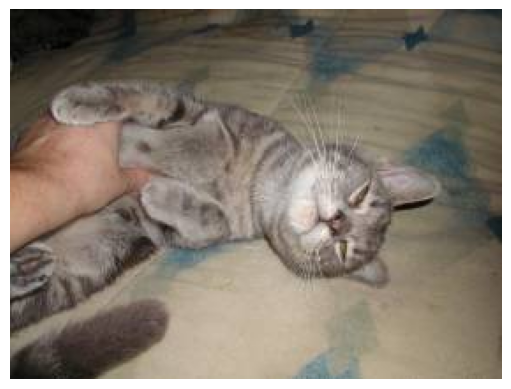

In [ ]:
train_dataset.view()
image, class_idx = train_dataset[0]
train_dataset.train()

print(f'train sample: {image.shape = }, class: {train_dataset.get_class_name(class_idx.item())}')
plt.imshow(image);
plt.axis('off');

Визуализация изображения после преобразований. Запустите код несколько раз, чтобы увидеть то, как работают преобразования

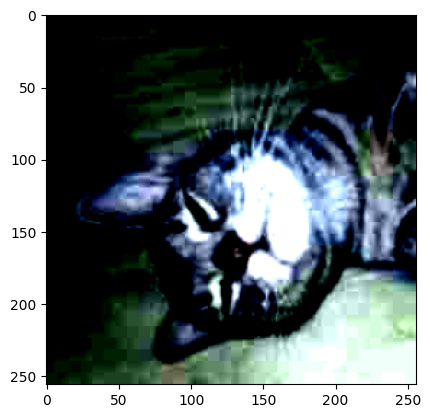

In [ ]:
plt.imshow(train_dataset[0][0].permute(1, 2, 0));

# Преобразование данных для передачи в ИНС

In [ ]:
def collate_fn(batch):
    inputs, targets = zip(*batch)

    inputs = torch.stack(inputs).to(dtype=torch.float, device=device)
    targets = torch.stack(targets).to(dtype=torch.float, device=device)
    targets = torch.unsqueeze(targets, 1)

    return inputs, targets

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn,
)

Для xb размер: batch size, num channels, size, size; для yb размер: batch size

In [ ]:
xb, yb = next(iter(train_loader))
xb.shape, yb.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32, 1]))

# Обучение модели

Загрузка модели классификации

In [ ]:
class MyCnn(nn.Module):
    def __init__(self):
        super(MyCnn, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(128 * 16 * 16, 1)


        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = MyCnn().to(device)

In [ ]:
model(xb).shape

torch.Size([32, 1])

Функция потерь

In [ ]:
criterion = nn.BCEWithLogitsLoss()

Критерий качества

In [ ]:
def my_accuracy(y_preds, y_true):
    y_preds = torch.sigmoid(y_preds)
    y_preds = (y_preds > 0.5).long()
    y_true = y_true.long()
    return (y_preds == y_true).float().mean().item()

Создание объекта learner

In [ ]:
callbacks = [
    CommonMetricsCallback( # callback для рассчёта значений метрик
        common_metrics={'accuracy': my_accuracy}, # словарь метрик, которые будут рассчитаны: "name": func(y_preds, y_true) -> number
    ),
    PrintCriteriaCallback() # callback для вывода значений критериев на экран
]

# Класс, выполняющий обучение ИНС
learner = BlissLearner(model,        # ИНС
                       criterion,    # Функция потерь
                       optim.Adam,   # Оптимизатор
                       {'lr': 1e-3}, # Параметры класса оптимизатора (обычно передаются в сам класс оптимизатора)
                       train_loader, # Загрузчик тренировочных данных
                       valid_loader, # Загрузчик валидационных данных
                       callbacks,    # Список callback
                       )

In [ ]:
learner.fit(20)

epoch: 1
training


batches:   0%|                                                                                                …

loss: 0.696
accuracy: 0.511

validating


batches:   0%|                                                                                                …

loss: 0.702
accuracy: 0.488

epoch: 2
training


batches:   0%|                                                                                                …

loss: 0.692
accuracy: 0.521

validating


batches:   0%|                                                                                                …

loss: 0.688
accuracy: 0.533

epoch: 3
training


batches:   0%|                                                                                                …

KeyboardInterrupt: 

Визуализация функции потерь и метрики

In [ ]:
train_info = learner.get_train_info()

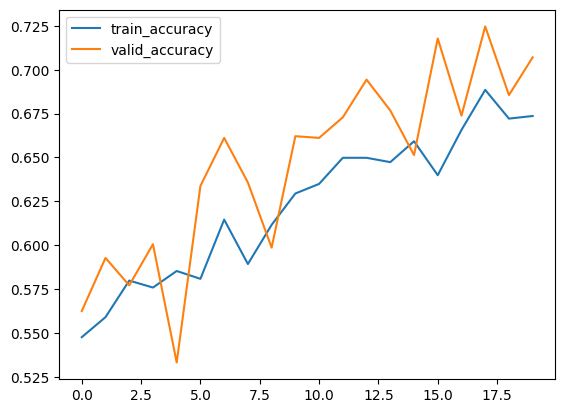

In [ ]:
plt.plot(train_info['train info']['accuracy'], label='train_accuracy')
plt.plot(train_info['eval info']['accuracy'], label='valid_accuracy')
plt.legend()
plt.show()

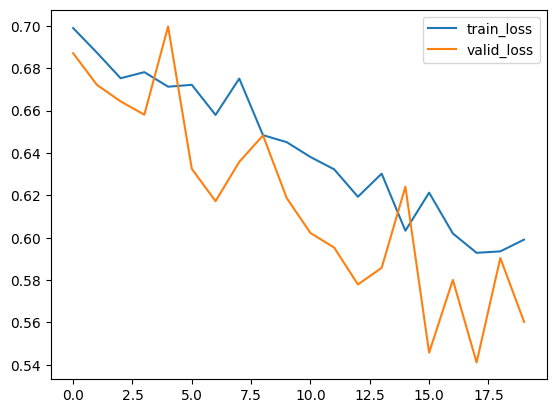

In [ ]:
plt.plot(train_info['train info']['loss'], label='train_loss')
plt.plot(train_info['eval info']['loss'], label='valid_loss')
plt.legend()
plt.show()